In [1]:
import pandas as pd
from textdistance import hamming
import numpy as np
from ast import literal_eval
import seaborn as sns
from pathlib  import Path
import matplotlib.pyplot as plt
from Bio.Seq import translate
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from Bio.codonalign.codonseq import cal_dn_ds, CodonSeq
from pandarallel import pandarallel
pandarallel.initialize()  # You can turn off progress bar if you like
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/athenes/.pyenv/versions/analysis/lib/python3.10/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


In [2]:
igG_germline = pd.concat([pd.read_csv(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_germline_{each}.csv.gz", usecols=["model_prediction_heavy","sequence_heavy","sequence_light"]) for each in range(900) if Path(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_germline_{each}.csv.gz").exists()])
igG_sequence = pd.concat([pd.read_csv(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_sequence_{each}.csv.gz", usecols=["model_prediction_heavy","sequence_heavy","sequence_light"]) for each in range(900) if Path(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_sequence_{each}.csv.gz").exists()])

In [3]:
briney = pd.read_table("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/316188_clonal_groups_with_aa.tsv.gz").dropna()
igG=briney.query("isotype.str.startswith('IgG')")

In [4]:
prediction_map = igG_sequence.set_index('sequence_heavy')['model_prediction_heavy'].to_dict()
igG['model_prediction_heavy_sequence'] = igG['sequence_aa'].map(prediction_map)
prediction_map = igG_germline.set_index('sequence_heavy')['model_prediction_heavy'].to_dict()
igG['model_prediction_heavy_germline'] = igG['germline_aa'].map(prediction_map)

/tmp/ipykernel_2362751/2838842722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  igG['model_prediction_heavy_sequence'] = igG['sequence_aa'].map(prediction_map)
/tmp/ipykernel_2362751/2838842722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  igG['model_prediction_heavy_germline'] = igG['germline_aa'].map(prediction_map)


In [5]:
import json
def process_df(df):
    df["paratope_heavy_sequence"]=df["model_prediction_heavy_sequence"].parallel_apply(json.loads)
    df["paratope_size_sequence"]=df["paratope_heavy_sequence"].parallel_apply(np.sum)
    df["normalized_paratope_size_sequence"]=df["paratope_size_sequence"]/df["sequence_aa"].str.len()

    df["paratope_heavy_germline"]=df["model_prediction_heavy_germline"].parallel_apply(json.loads)
    df["paratope_size_germline"]=df["paratope_heavy_germline"].parallel_apply(np.sum)
    df["normalized_paratope_size_germline"]=df["paratope_size_germline"]/df["germline_aa"].str.len()

    df["mutation_count"]=df[["sequence_aa", "germline_aa"]].parallel_apply(
            lambda x: hamming(*x),
            axis=1,
        )
    return df

In [6]:
ig_filtered = process_df(igG.dropna())
ig_filtered["delta_paratope_size"]=ig_filtered["paratope_size_sequence"]-ig_filtered["paratope_size_germline"]

/tmp/ipykernel_2362751/3502409425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["paratope_heavy_sequence"]=df["model_prediction_heavy_sequence"].parallel_apply(json.loads)
/tmp/ipykernel_2362751/3502409425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["paratope_size_sequence"]=df["paratope_heavy_sequence"].parallel_apply(np.sum)
/tmp/ipykernel_2362751/3502409425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [7]:
print(len(ig_filtered))

3506538


In [8]:
plt.rcParams.update({
    "axes.labelsize": 30,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

In [9]:
ig_filtered['mean_delta_paratope_size'] = ig_filtered.groupby('clone_id')['delta_paratope_size'].transform('mean')
ig_filtered['mean_sequence_paratope_size'] = ig_filtered.groupby('clone_id')['paratope_size_sequence'].transform('mean')

/tmp/ipykernel_2362751/2468983182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_filtered['mean_delta_paratope_size'] = ig_filtered.groupby('clone_id')['delta_paratope_size'].transform('mean')
/tmp/ipykernel_2362751/2468983182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_filtered['mean_sequence_paratope_size'] = ig_filtered.groupby('clone_id')['paratope_size_sequence'].transform('mean')


In [13]:
ig_filtered["clone_size"] = ig_filtered["clone_id"].map(ig_filtered["clone_id"].value_counts())

/tmp/ipykernel_2362751/2753325354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_filtered["clone_size"] = ig_filtered["clone_id"].map(ig_filtered["clone_id"].value_counts())


/tmp/ipykernel_2362751/2056220119.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2362751/2056220119.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2362751/2056220119.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2362751/2056220119.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


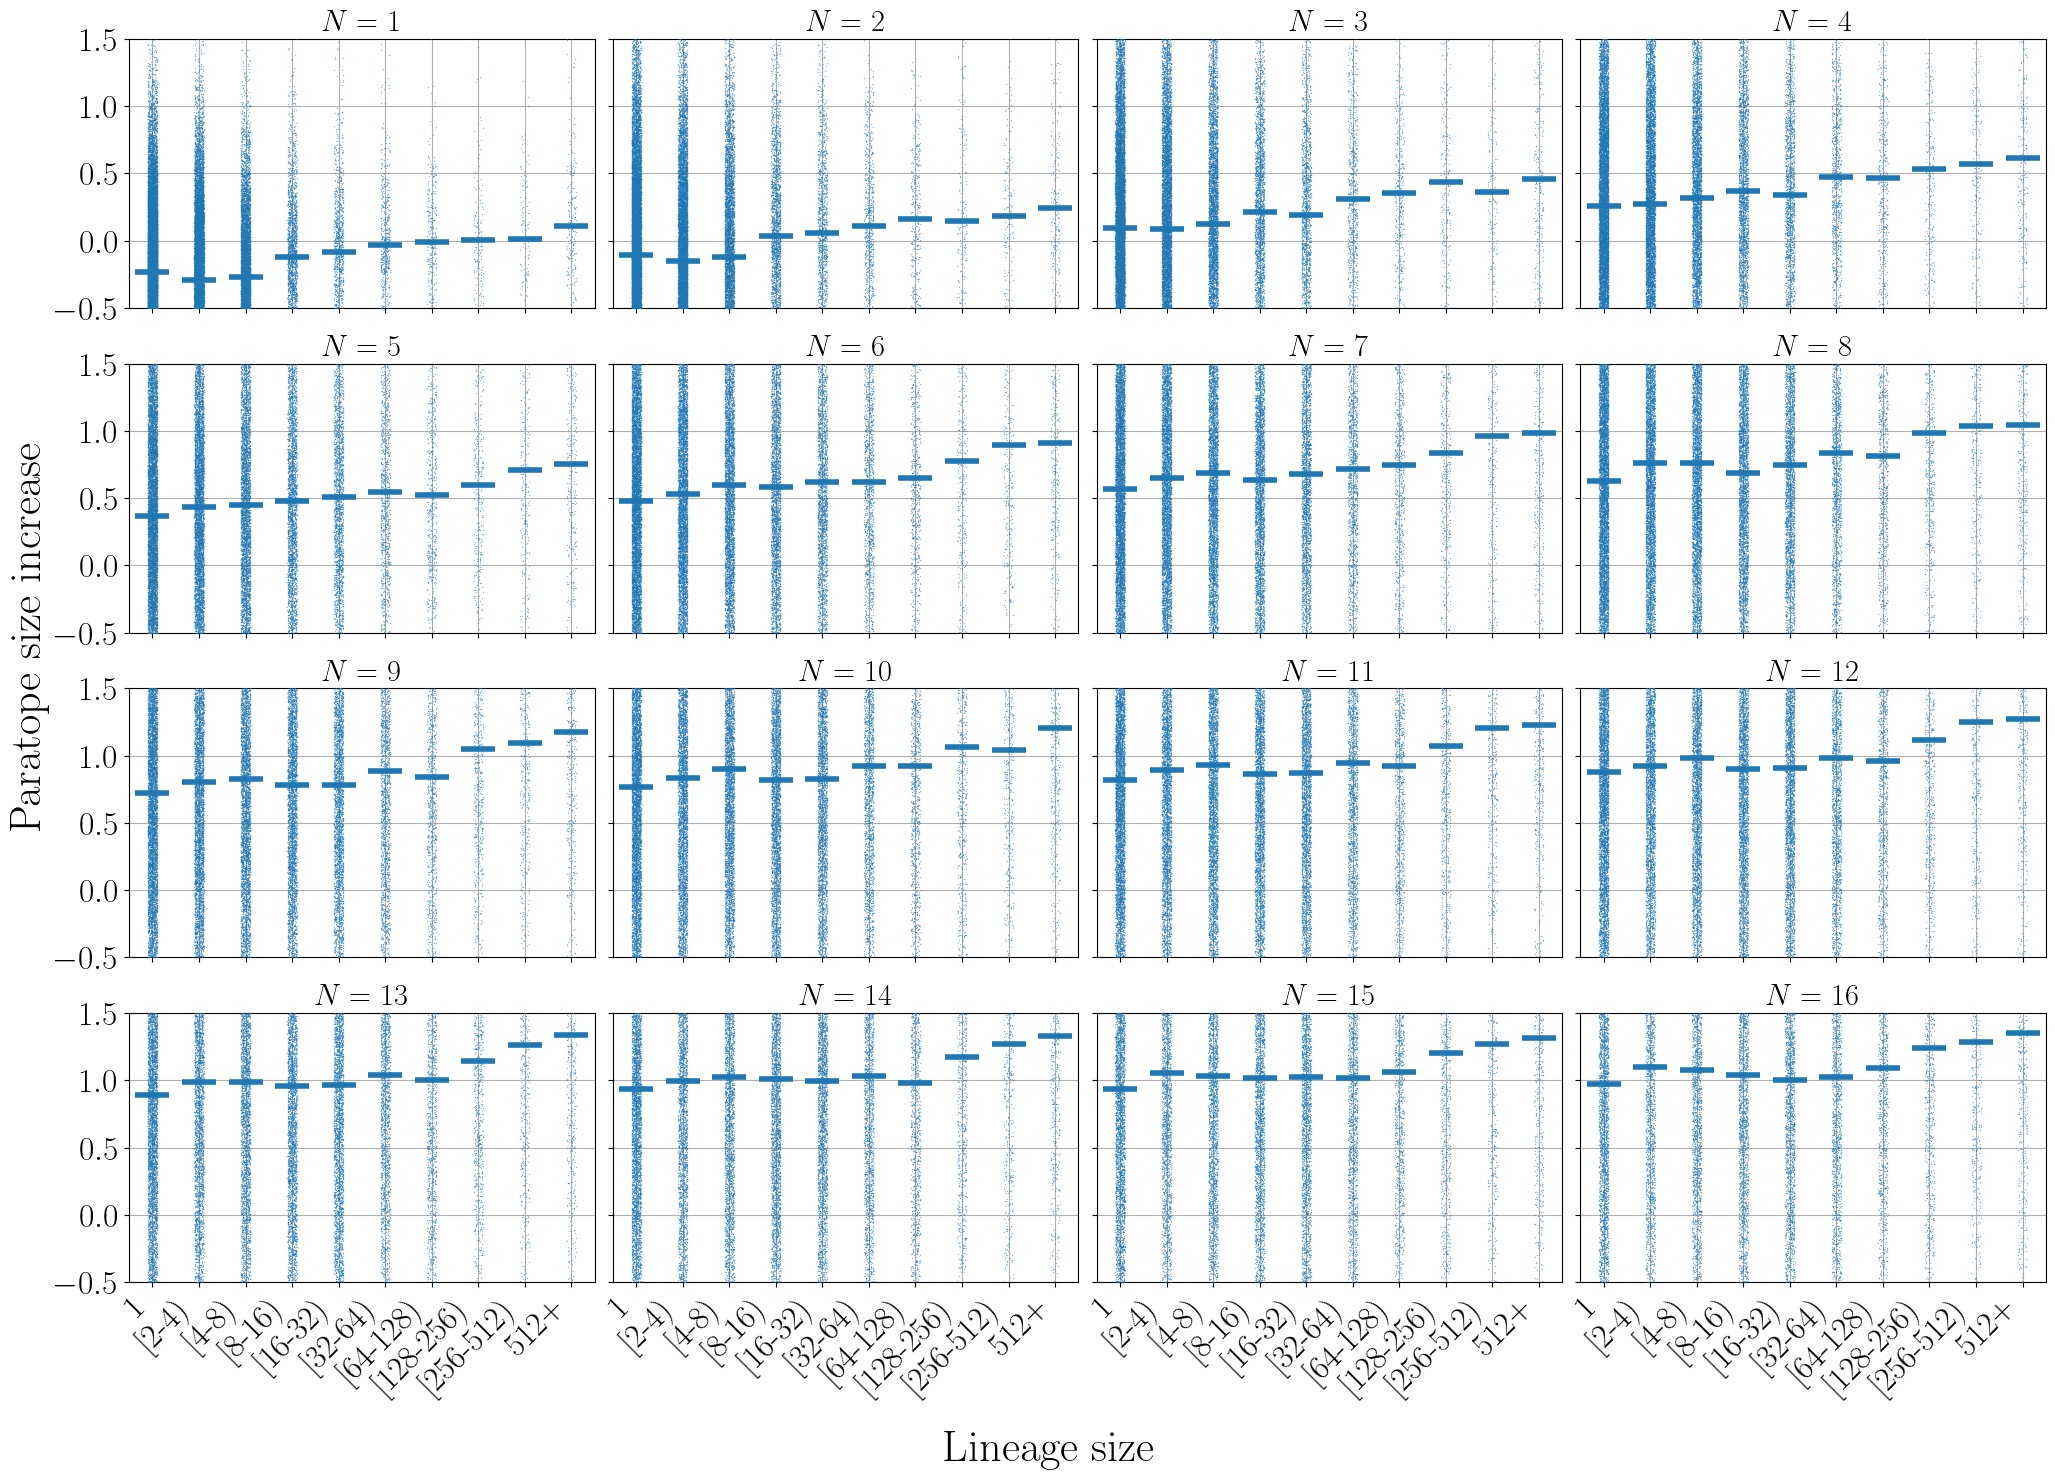

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Custom bin settings
custom_bins = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, np.inf]
bin_labels = ['1', '[2-4)', '[4-8)', '[8-16)', '[16-32)', '[32-64)', '[64-128)', '[128-256)', '[256-512)', '512+']

# Create 4x4 subplots for mutations 1–16
fig, axes = plt.subplots(4, 4, figsize=(20, 14), constrained_layout=True)
axes = axes.flatten()

# Mutation range
mutation_range = range(1, 17)

for idx, mut in enumerate(mutation_range):
    ax = axes[idx]

    # Filter and group
    grouped_df = (
        ig_filtered.query("mutation_count==@mut").groupby('clone_id')
        .agg(
            mean_delta_paratope_size=('delta_paratope_size', 'mean'),
            mean_sequence_paratope_size=('paratope_size_sequence', 'mean'),
            clone_size=('clone_size', 'mean')
        )
        .reset_index()
    )

    if grouped_df.empty:
        ax.set_title(f'N={mut} (no data)')
        ax.axis('off')
        continue

    # Bin clone sizes
    grouped_df['Bin'] = np.digitize(grouped_df['clone_size'], bins=custom_bins, right=False)
    grouped_df['Bin Label'] = grouped_df['Bin'].apply(
        lambda x: bin_labels[x - 1] if 0 < x <= len(bin_labels) else 'Outlier'
    )

    # Plot
    sns.stripplot(
        x='Bin Label',
        y='mean_delta_paratope_size',
        data=grouped_df,
        size=1,
        jitter=True,
        order=bin_labels,
        alpha=0.5,
        ax=ax
    )
    sns.pointplot(
        x='Bin Label',
        y='mean_delta_paratope_size',
        data=grouped_df,
        order=bin_labels,
        linestyle="none",
        errorbar=None,
        marker="_",
        markersize=25,
        markeredgewidth=4,
        ax=ax
    )

    ax.set_title(f'$N={mut}$', fontsize=22)
    ax.set_ylim([-0.5, 1.5])
    ax.grid(True)
    ax.set_xlabel('')  # Custom x-axis label
    ax.set_ylabel('')
    # Remove y-axis labels and ticks for columns 2–4
    if idx % 4 != 0:
        ax.set_yticklabels([])

    # Remove x-axis labels and ticks for rows 1–3
    if idx < 12:
        ax.set_xticklabels([])

    # Rotate x labels for bottom row
    if idx >= 12:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Global x and y labels
fig.text(0.5, -0.04, r'Lineage size', ha='center', fontsize=32)
fig.text(-0.02, 0.55, r'Paratope size increase', va='center', rotation='vertical', fontsize=32)

# Save and show
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure_si6.pdf", bbox_inches='tight')

plt.show()


in methods: put a part about data processing
y label:  paratope size increase
change scatter plots : figure 4E dezoom a bit
remove si5
things with positive selection, negative selection : remove
error bars for 4A
remove 5D replace by control,
deoom
